In [38]:
import os
from datetime import datetime, timedelta
from itertools import chain

import mplfinance as mlf
import plotly.graph_objects as go
import pandas as pd
import yfinance
from summarytools import dfSummary

In [ ]:
ROOT_FOLDER = '.'
OUTPUT_FOLDER = 'data'
REPLACE = False

In [3]:
def download_security(
        security: str,
        start_date: datetime,
        end_date: datetime,
        time_frame: str
) -> pd.DataFrame:
    df = yfinance.download(
        tickers=security,
        start=start_date,
        end=end_date,
        interval=time_frame
    )
    df = df.droplevel(1, axis=1)
    return df

In [4]:
def get_folder_nm(
        security: str,
        time_frame: str
) -> str:
    return os.path.join(ROOT_FOLDER, OUTPUT_FOLDER, security, time_frame)

In [5]:
def get_file_name(
        security: str,
        start_date: datetime,
        end_date: datetime,
        time_frame: str
) -> str:
    return f'{security}_{time_frame}_{start_date}_{end_date}.parquet'

In [6]:
def path_handler(
        security: str,
        start_date: datetime,
        end_date: datetime,
        time_frame: str
) -> str:
    folder_path = os.path.join(ROOT_FOLDER, OUTPUT_FOLDER, security, time_frame)
    file_nm = f'{security}_{time_frame}_{start_date}_{end_date}.parquet'
    file_path = os.path.join(folder_path, file_nm)

    if os.path.exists(file_path):
        raise FileExistsError(f'The file has been already downloaded')
    else:
        os.makedirs(folder_path, exist_ok=True)
    return file_path

In [7]:
def save_security(df: pd.DataFrame, file_path: str) -> None:
    df.to_parquet(path=file_path, compression='gzip', index=False)

### 3. Создать код на Python, который загрузит на ваш локальный компьютер данные о котировках ценных бумаг из списка SnP500 и котировки криптовалют (BTC, ETH, SOL, XRP).

In [11]:
sp500_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'META'] 
crypto_tickers = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'XRP-USD']

start_date = '2024-01-01'
end_date = '2024-11-01'
time_frame = '1d'


for security in chain(sp500_tickers, crypto_tickers):
    print(f'\n{security}')
    
    try:
        file_path = path_handler(security, start_date, end_date, time_frame)
    except FileExistsError as e:
        print(str(e))
        if REPLACE:
            print('Replacing...')
        else:
            print('Skipping.')
            continue

    print(f'Downloading...')
    df = download_security(security, start_date, end_date, time_frame)
    print(f'Done. {len(df)} rows')

    save_security(df, file_path)
    print(f'Saved to: {file_path}')


AAPL
The file has been already downloaded
Skipping.

MSFT
The file has been already downloaded
Skipping.

AMZN
The file has been already downloaded
Skipping.

GOOG
The file has been already downloaded
Skipping.

META
The file has been already downloaded
Skipping.

BTC-USD
The file has been already downloaded
Skipping.

ETH-USD
The file has been already downloaded
Skipping.

SOL-USD
The file has been already downloaded
Skipping.

XRP-USD
The file has been already downloaded
Skipping.


### 4. Поскольку вам предстоит много работать с ними в дальнейшем, подготовьте автоматическое отображение графиков текущей ситуации.

In [32]:
security = 'AAPL'
last_n_days = 30
time_frame = '1h'

start_date = datetime.now() - timedelta(days=last_n_days)
end_date = datetime.now()

security_df = download_security(security, start_date, end_date, time_frame)

candlestick = go.Figure(
    data=[
        go.Candlestick(
            x=security_df.index,
            open=security_df['Open'],
            high=security_df['High'],
            low=security_df['Low'],
            close=security_df['Close']
        )
    ]
)

candlestick.update_layout(
    title=f'{security} Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Stock Price (USD)',
    xaxis_rangeslider_visible=False
)

candlestick.show()

[*********************100%***********************]  1 of 1 completed


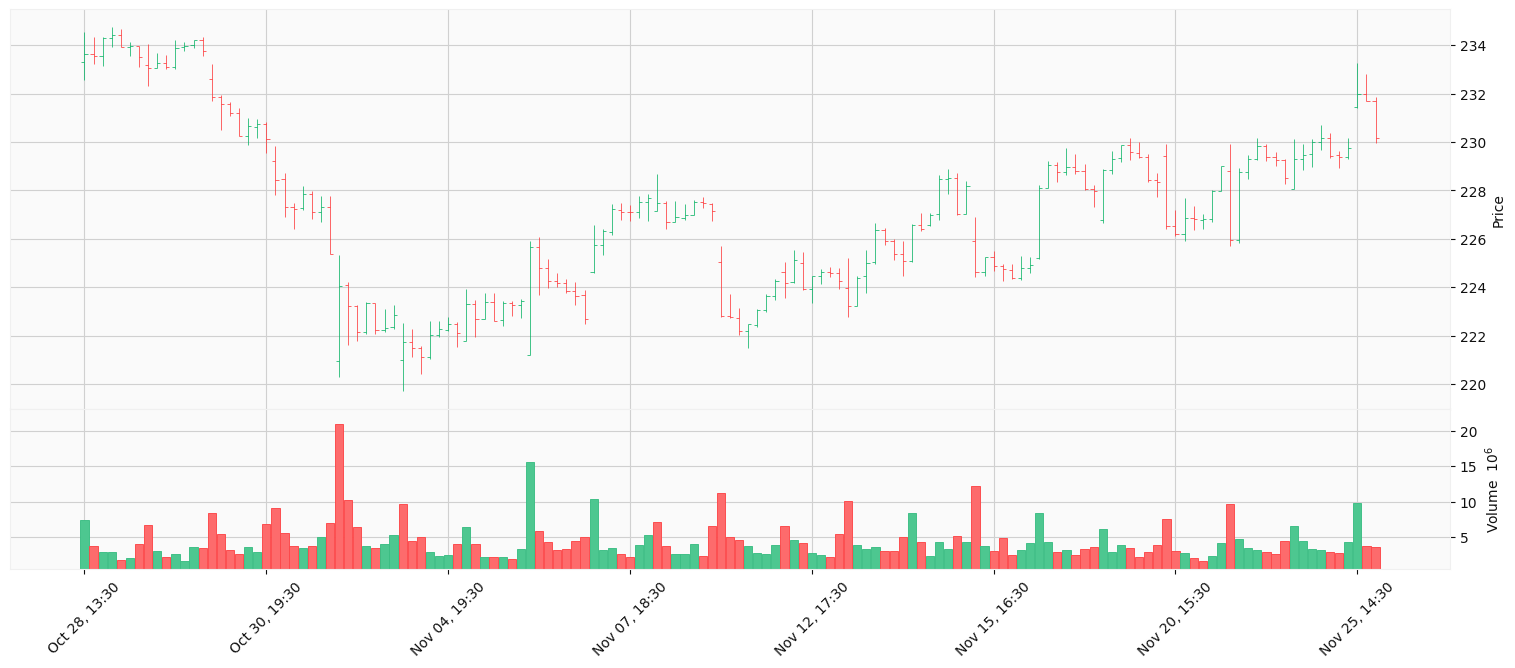

In [33]:
mlf.plot(security_df, volume=True, style='yahoo', figsize=(20, 8));

### 5. Проверьте нет ли в данных пропусков или ошибок. Проанализируйте выбросы. Оцените, на самом ли деле это выбросы или реальные данные, с которыми предстоит работать.


In [34]:
security_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2024-10-28 13:30:00+00:00 to 2024-11-25 16:30:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  143 non-null    float64
 1   Close      143 non-null    float64
 2   High       143 non-null    float64
 3   Low        143 non-null    float64
 4   Open       143 non-null    float64
 5   Volume     143 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 7.8 KB


In [30]:
security_df.isna().sum()

Price
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [36]:
q_25 = security_df.quantile(0.25)
q_75 = security_df.quantile(0.75)
iqr = q_75 - q_25

In [ ]:
# Есть необычно высокие объемы торгов
((security_df < (q_25 - 1.5 * iqr)) | (security_df > (q_75 + 1.5 * iqr))).sum()

Price
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume       14
dtype: int64

In [40]:
dfSummary(security_df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Adj Close[float64],Mean (sd) : 227.1 (3.4)min < med < max:221.1 < 227.0 < 234.4IQR (CV) : 5.0 (66.4),142 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACp0lEQVR4nO3dQW7aQBiG4X9KiAxIthAS7LhApS5YcogetkfoghNwA3ZICBnhxsIYd9GmSiVIYGYc5h/eZz/JRPpkzzfx2KZpGgFC9+XeEwCu8XTvCYTKGNMTkWfL4YemaV58zufREdQzjDG90Wj0PU3Toc343W63Ncb8IKz+ENTzntM0Hc7n85csy8pbBuZ5niwWi+Fms3kWEYLqCUF9R5Zl5Xg8/mUxtOd9Mg+OMgUVCCpUCPrWT/PGq2CDSvPGW8EGVWjeeCPkoIoIzRt/UKagAkGFCq3e+h1be3o6nbo+5/NZ6rruikhqjLEZzm7FGa0F1bW1V1WV1HX9tSzLnyJis0a9i6IoulVVfZtOp51Op3NTCRRht+KSNq+o1q1dRGS1Wg2Xy2X/eDx22phcWw6Hw1OSJP3ZbFZOJpPtLWPZrbis9dZv29q3263q1j4YDKz+7rquU7FfNohEunQIfnvqkbguG0TiXToQ1IC4LBtE4l46ENQA2S4b/lK9ZLqEfVSoQFChAkGFCgQVKhBUqEBQoQJBhQoEFSoQVKhAUKEC/0KFN20ebyeo8KLt4+0EFb60erw92qA6nltSe17r3to63h5lUF0fQNZ6XitmUQbV9QFkree1YhZlUF/ZPoCs/bxWjNhHhQoEFSp8eOt32MSlOcObd4PqsolLc4ZPH11RrTdxac7w6arWb7OJS3OGT5QpqEBQoQJBhQoEFSoQVKhAUKECQYUKBBUqEFSoQFChAkGFClE/4f+IYv0YG0GNSMwfYyOoEYn5Y2wENUIOX1UJ9tFMyhRU4IqKf0J+uwxBhYiE/3YZggoRCf/tMgQV/wn17TKUKahAUKECQYUKBBUqEFSocFXrz/M8ufUH7/f7RESkKIpkvV73P3O81t+tdd6u46/J12/M4bzOPB6u8QAAAABJRU5ErkJggg=="">",0(0.0%)
2,Close[float64],Mean (sd) : 227.1 (3.4)min < med < max:221.1 < 227.0 < 234.4IQR (CV) : 5.0 (66.4),142 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACp0lEQVR4nO3dQW7aQBiG4X9KiAxIthAS7LhApS5YcogetkfoghNwA3ZICBnhxsIYd9GmSiVIYGYc5h/eZz/JRPpkzzfx2KZpGgFC9+XeEwCu8XTvCYTKGNMTkWfL4YemaV58zufREdQzjDG90Wj0PU3Toc343W63Ncb8IKz+ENTzntM0Hc7n85csy8pbBuZ5niwWi+Fms3kWEYLqCUF9R5Zl5Xg8/mUxtOd9Mg+OMgUVCCpUCPrWT/PGq2CDSvPGW8EGVWjeeCPkoIoIzRt/UKagAkGFCq3e+h1be3o6nbo+5/NZ6rruikhqjLEZzm7FGa0F1bW1V1WV1HX9tSzLnyJis0a9i6IoulVVfZtOp51Op3NTCRRht+KSNq+o1q1dRGS1Wg2Xy2X/eDx22phcWw6Hw1OSJP3ZbFZOJpPtLWPZrbis9dZv29q3263q1j4YDKz+7rquU7FfNohEunQIfnvqkbguG0TiXToQ1IC4LBtE4l46ENQA2S4b/lK9ZLqEfVSoQFChAkGFCgQVKhBUqEBQoQJBhQoEFSoQVKhAUKEC/0KFN20ebyeo8KLt4+0EFb60erw92qA6nltSe17r3to63h5lUF0fQNZ6XitmUQbV9QFkree1YhZlUF/ZPoCs/bxWjNhHhQoEFSp8eOt32MSlOcObd4PqsolLc4ZPH11RrTdxac7w6arWb7OJS3OGT5QpqEBQoQJBhQoEFSoQVKhAUKECQYUKBBUqEFSoQFChAkGFClE/4f+IYv0YG0GNSMwfYyOoEYn5Y2wENUIOX1UJ9tFMyhRU4IqKf0J+uwxBhYiE/3YZggoRCf/tMgQV/wn17TKUKahAUKECQYUKBBUqEFSocFXrz/M8ufUH7/f7RESkKIpkvV73P3O81t+tdd6u46/J12/M4bzOPB6u8QAAAABJRU5ErkJggg=="">",0(0.0%)
3,High[float64],Mean (sd) : 227.7 (3.4)min < med < max:221.6 < 227.6 < 234.7IQR (CV) : 4.9 (67.1),135 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3dTariQBSG4VPt9RIVEkTQmRto6IFDF9GL7SX0wBW4A2eCSETvFf/So25ouPiTSml9yfvMS+vAh1I5J4krisKA2H179QaAe7y9egOxcs51zOy95PJDURSfVe6n6QjqF5xzncFg8DNN036Z9ZvNZu2c+0VYq0NQv/aepml/Op1+Zlm2f2RhnufJbDbrr1ardzMjqBUhqFdkWbYfDocfJZZ2Kt9Mw3GYggSCCglR//U38eTtWbOZaN23RBvUJp68fWs206z7HtEG1Zp58i5ds5l03TfFHFQza+bJ26NmM+G6r+EwBQkEFRIIKiQQVEggqJBAUCGBoEICQYWEoBf8PfvW6eVyaVe5n2c5n89tM0udc48ula05tGBB9e1bH4/H5Hw+f9/v97/NrGyX5ul2u137eDz+GI/HrVar9VAbVLXmZwj5i+rVt14sFv35fN49nU6tEJsL5XA4vCVJ0p1MJvvRaLR+ZK1qzc8QvNdftm+9Xq+le9a9Xu/hutVrDonDFCQQVEggqJBAUCEh+sFp6Ah5jxtBRSVC3+NGUFGVoPe4EVRUKtQ9bhymIIGgQkJt//o9JpjMmGKKTi2D6jPBZMYUU4xqGVSfCSYzpphiVMug/lVmgsmMKaYYcZiCBIIKCQQVEggqJBBUSCCokEBQIYGgQsLNC/4eU9v0y1GZq0H1mdqmX44q3fpFLT21Tb8cVbqr119mapt++Wt4jjdG+zK1Wg+lNI3veGPML1MjqDXiM94Y+8vUCGoNlR1vtIhfpsZ1VEggqJBAUCGBoEICQYUEggoJBBUSuI6Kf2J+ugxBhZnF/3QZggozi//pMgQV/4n16TIcpiCBoEICQYUEggoJBBUS7jr153mePPrB2+02MTPb7XbJcrnsPnO96ner7tt3/T35+gMc4bLpXNTGYwAAAABJRU5ErkJggg=="">",0(0.0%)
4,Low[float64],Mean (sd) : 226.4 (3.5)min < med < max:219.7 < 226.4 < 233.9IQR (CV) : 5.0 (64.2),141 distinc